In [2]:
from torchvision import models
import torchvision
import torch

NOTE: The capitalized names are the blueprints for different models, and the lowercase names are the tools that actually build those models for you. This makes it easier to experiment with different model architectures and find the best one for your deep learning project.

In [3]:
print("First five and last five models: ", dir(models)[:5], dir(models)[-5:])

First five and last five models:  ['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights'] ['vit_h_14', 'vit_l_16', 'vit_l_32', 'wide_resnet101_2', 'wide_resnet50_2']


In [4]:
# alexnet = models.AlexNet()

In [5]:
resnet101 = models.resnet101(weights='ResNet101_Weights.DEFAULT')
resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# print(resnet50)

In [6]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229,0.224,0.225]
    )
])

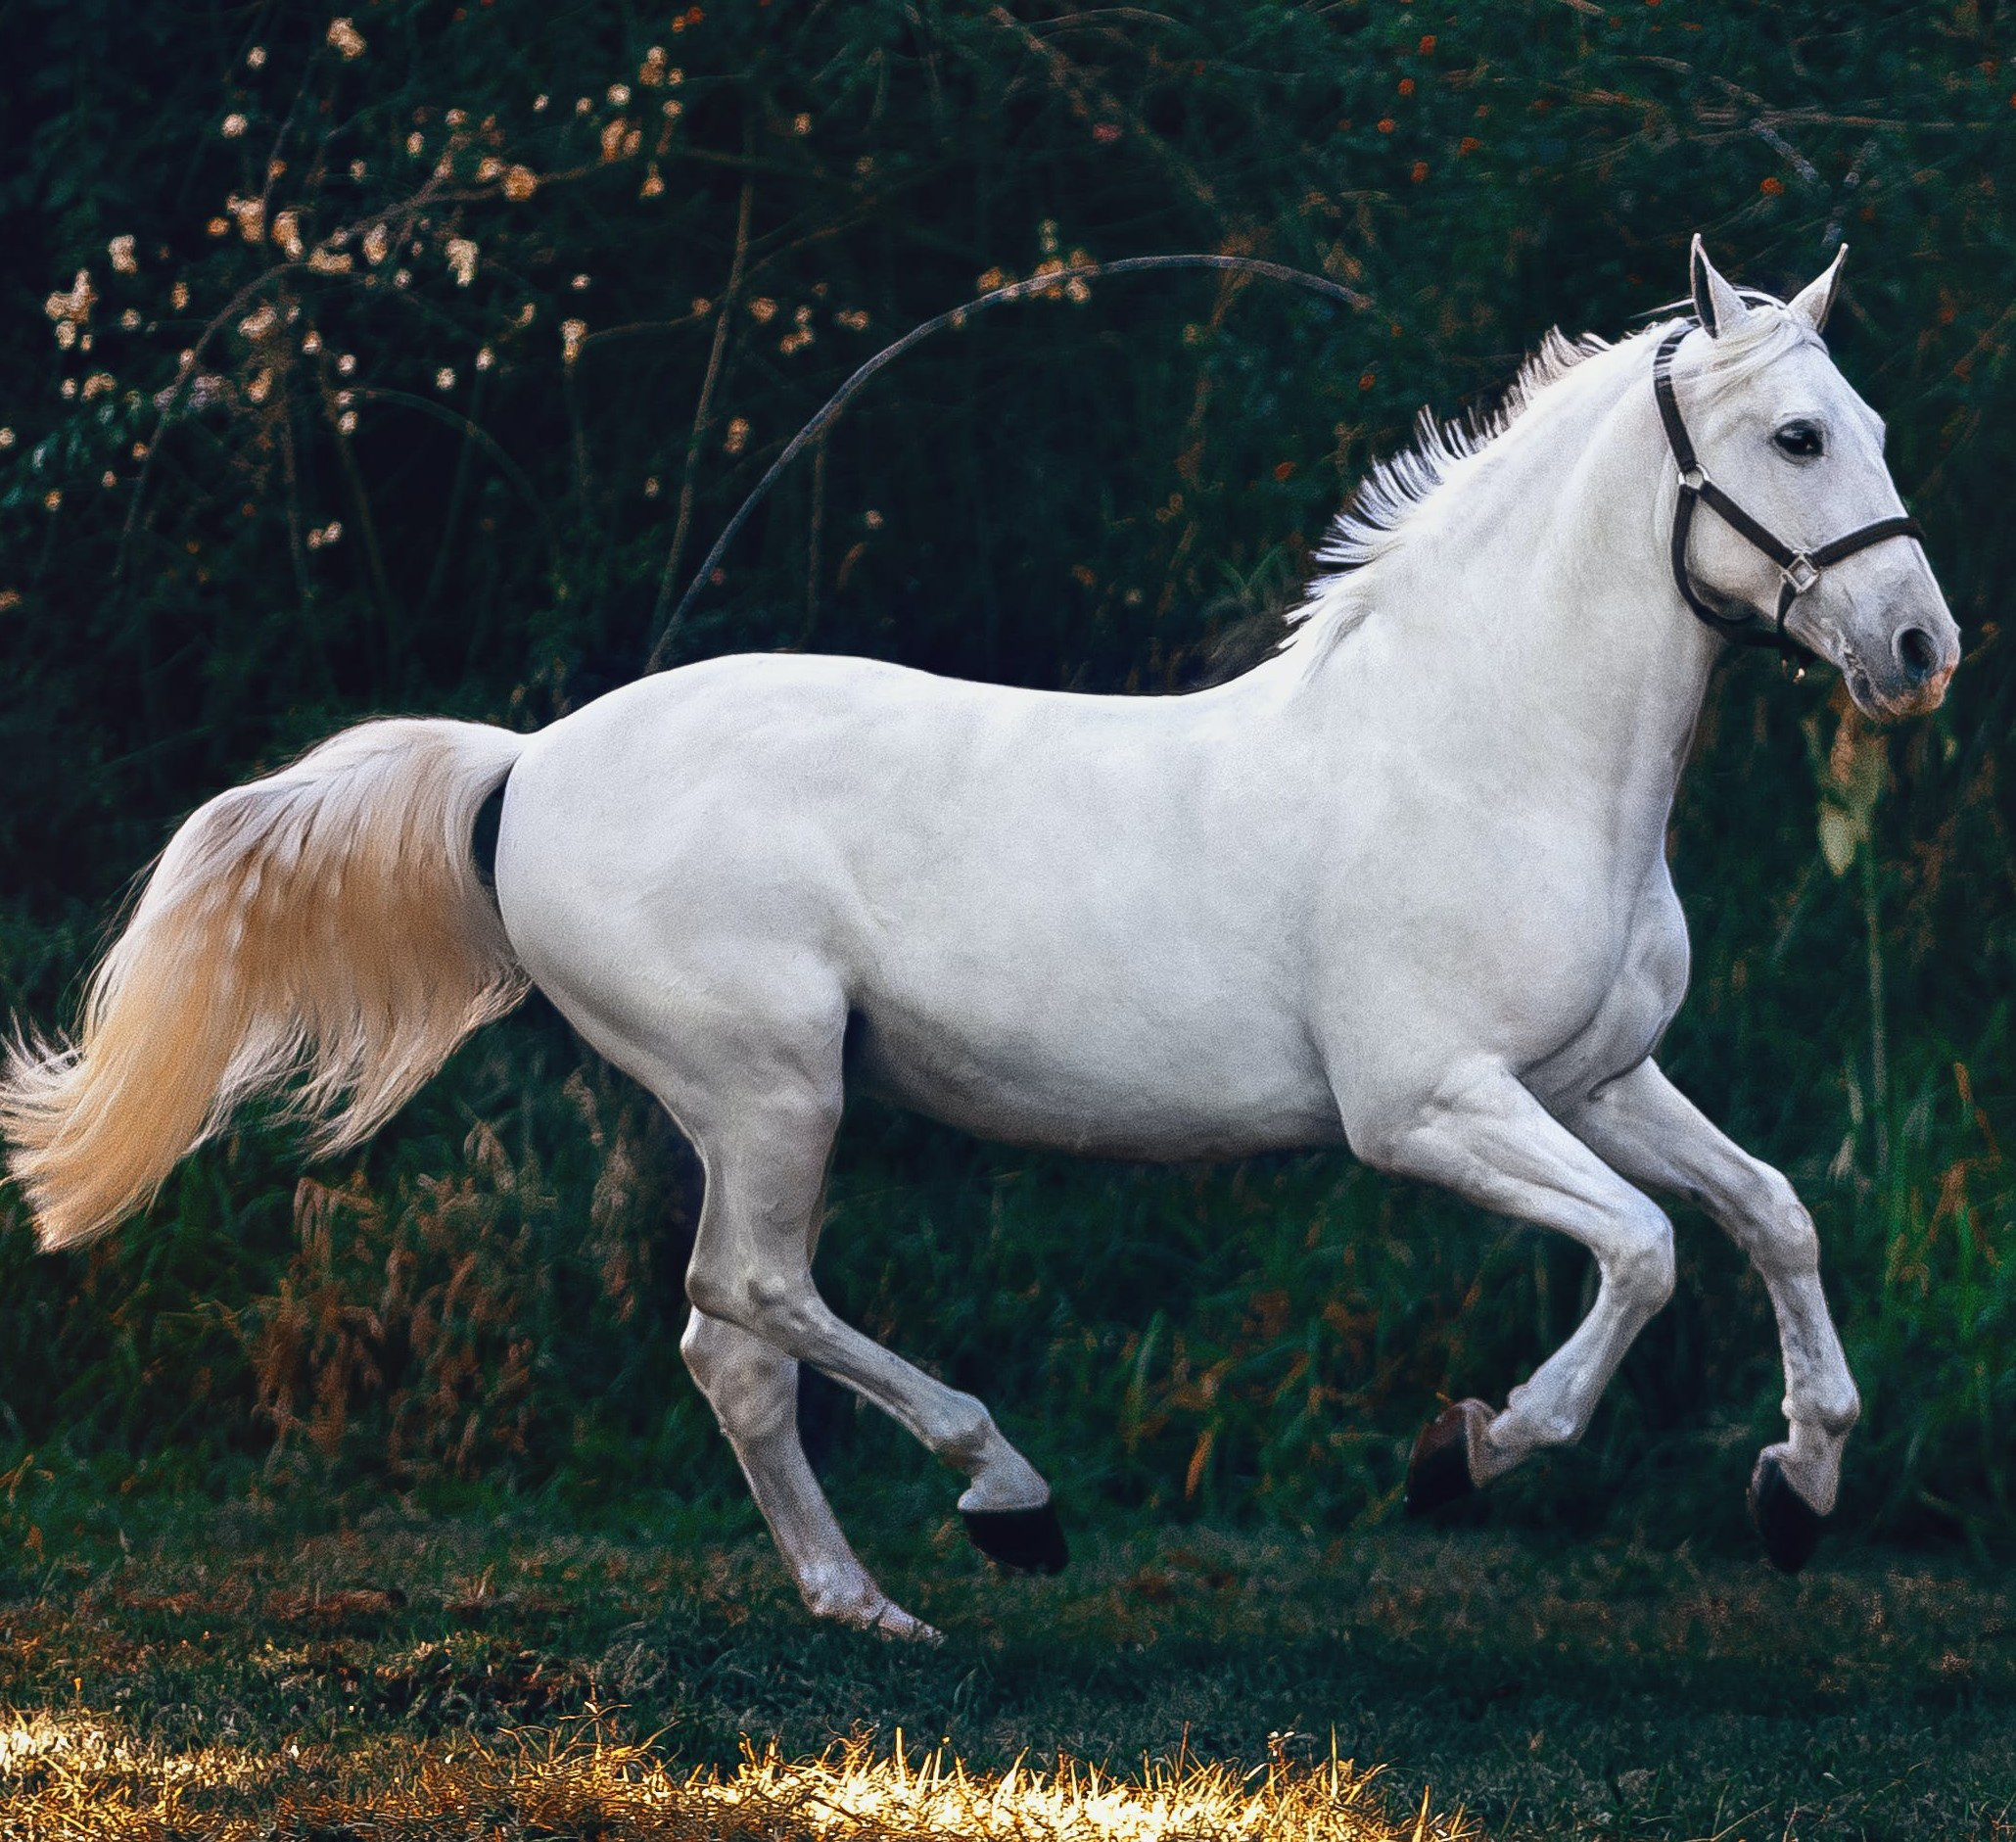

In [7]:
from PIL import Image
# img = Image.open('../data/chapter_2/00511_001368421239231.jpg').convert('RGB')
# img = Image.open('../data/chapter_2/horse.jpg').convert('RGB')
img = Image.open('../data/chapter_2/horse.jpeg').convert('RGB')
img

In [8]:
img.getchannel

<bound method Image.getchannel of <PIL.Image.Image image mode=RGB size=2059x1881 at 0x1078AC7C0>>

In [9]:
img_t = preprocess(img)
print(img_t.size())
# img_t

torch.Size([3, 224, 224])


In [10]:

batch_t = torch.unsqueeze(img_t, 0)

In [11]:
resnet101.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
out = resnet101(batch_t)
print(out.size())
# print(out)

torch.Size([1, 1000])


In [13]:
with open('../data/chapter_2/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]
# labels

In [14]:
_, index = torch.max(out, 1)
index

tensor([339])

In [15]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
percentage_max = torch.max(percentage, 0)
print(percentage_max)
# print(percentage)


torch.return_types.max(
values=tensor(33.1853, grad_fn=<MaxBackward0>),
indices=tensor(339))


I am adding due to imagenet_classes file have first four lines of header text +4

In [16]:
print(labels[index[0]+4].split(',')[1], percentage[index[0]].item())


 sorrel 33.18528747558594


### 2.2.3 A Network that turns horses into zebras

The dataset link horese2zebra 👉
1. https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/
2. https://www.kaggle.com/datasets/balraj98/horse2zebra-dataset

In [ ]:
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [ ]:
netG = ResNetGenerator()

In [ ]:
model_path = '../data/chapter_2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

In [ ]:
netG.eval()

In [ ]:
preprocess = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

In [ ]:

batch_out = netG(batch_t)

In [ ]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img

### 2.4 TorchHub

In [ ]:
from torch import hub

In [ ]:
resnet18_model = hub.load('pytorch/vision:main', 'resnet18')

##### To test the model from other repo which has the hubconf.py 

In [ ]:
# https://github.com/ultralytics/yolov5/blob/master/hubconf.py
# yolov5n(pretrained=True, channels=3, classes=80, autoshape=True, _verbose=True, device=None)

yolo5_model = hub.load('ultralytics/yolov5:master', 'yolov5n')


In [ ]:
yolo5_model.eval()

In [ ]:
batch_out = yolo5_model(batch_t)
batch_out